# Build the network of Rock Performers

**Getting a list of the titles:**

In [84]:
import re
import os
import networkx as nx
import matplotlib.pyplot as plt

text = open("wiki")
pattern = re.compile(r"\[\[(?!File:|Image:|Category:|Template:)([^\]|#]+)(?:\|([^\]]+))?\]\]")
matches = pattern.findall(text.read())
titles = []
for title, display in matches:
    url_title = title.replace(" ", "_")
    titles.append(url_title)

artists = set(titles)
artists.discard("AllMusic")

**Making the Graph and adding nodes and links:**

In [85]:
G = nx.DiGraph()
folder = "wiki_pages"

link_pattern = re.compile(r"\[\[(?!File:|Image:|Category:|Template:)([^\]|#]+)(?:\|([^\]]+))?\]\]")

for filename in os.listdir(folder):
    if filename.endswith(".txt"):
        filepath = os.path.join(folder, filename)
        with open(filepath, "r", encoding="utf-8") as f:
            text = f.read()

        node = os.path.splitext(filename)[0]
        word_count = len(re.findall(r"\w+", text))
        G.add_node(node, len_of_content=word_count)

        matches = link_pattern.findall(text)
        for link, display in matches:
            link_safe = link.replace(" ", "_").replace("/", "_")
            if link_safe in artists:
                G.add_edge(node, link_safe)

print(f"Number of nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")

Number of nodes: 488, edges: 7283


**Removing isolated nodes:**

In [86]:
isolated_nodes = list(nx.isolates(G))
print(f"Number of isolated nodes:", {len(isolated_nodes)})
G.remove_nodes_from(isolated_nodes)

Number of isolated nodes: {4}


**Extracting the largest component.**

*Notice it's just the graph without the isolated nodes.*

In [87]:
largest_cc = max(nx.weakly_connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()

print(f"Number of nodes: {G_largest.number_of_nodes()}, edges: {G_largest.number_of_edges()}")

Number of nodes: 484, edges: 7283


# Document how you crawled the network.

***First, simply describe the steps of the process (what you did, step by step):***

We started by simply copying the wiki-site into at txt file called wiki.txt.
From this we could use RegEx to find all Rock Musicians on the page and create a list of their names/titles.

We could then loop through all the names in the list, and use the urllib to load the wiki-page corresponding to each of the artists and safe the data in a .txt file in a folder.
In this part we had some trouble, since we were forbidden acces to the wiki API, but we then added a header to our request, giving permission.

Next up we created a DiGraph using NetworkX.

We then looped through the files in the folder, and for each file we added the name of it as a node in the graph. We counted the number of words in the file and added that number as an "attribute" to the node.
We then used RegEx to look through the file to match which wiki-pages in linked too. If the page it linked to was in out list of artists, then the link would be added as an edge.

We then removed the isolated nodes (there were 4), and extracted the largest component. Which was the same graph as when removing the isolated nodes in this coincidence.

***Then, write a short section about which part of the process that was most difficult:***

The Regular Expression were a bit challenging, since we were not that used to thinking in that way - and it takes some getting used to. We also, by mistake, matched more words than we wanted to, and had to manually remove one name from the list (AllMusic).

Other than that it was also challenging to figure out how to download all the wiki-pages. We are still not that used to using API's and hadn't tried it other than in week 1. But it was good to get a refresh. Also figuring out how to skip the redirected pages.

***Next write a short section about how you used LLMs to help you:***

We used LLM primarly with making the RegEx - and understanding how to "build" them.
Besides that we also had help making the download loop, especially figuring out how the make a header such that we were not forbidden access, and also how to skip the redirected links.


***Finally, compose a short section about what you would do differently if you had to do it again:***

Everything turned in to a bit of a mess, so structuring the different code files would be nice to do from the beginning.

We would also run smaller sets in the beginning, until we knew that our script worked. Here we let it download all the pages before being sure that it worked, which wasn't that smart.

# Simple network statistics and analysis

In [89]:
import numpy as np

# Getting the size of G
num_nodes = G_largest.number_of_nodes()
num_edges = G_largest.number_of_edges()

Our network has 485 nodes and 7324 links.

**Next we look at the distribution of the number of in-degrees, and create a scale-free network which we compare with.**

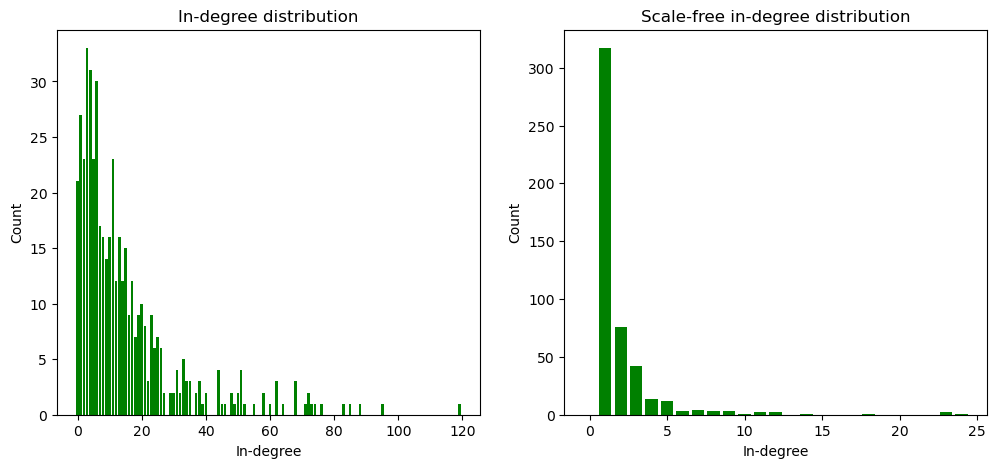

In [90]:
# In degrees for G
in_degrees = [G_largest.in_degree(n) for n in G_largest.nodes()]

# Creating the scale-free network
G_sf = nx.barabasi_albert_graph(num_nodes, 1)  
sf_in_degrees = [G_sf.degree(n) for n in G_sf.nodes()]

# Making histogram for G and the scale-free network
in_hist, in_bins = np.histogram(in_degrees, bins=range(max(in_degrees)+2))
sf_in_hist, sf_in_bins = np.histogram(sf_in_degrees, bins=range(max(sf_in_degrees)+2))

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].bar(in_bins[:-1], in_hist, color='g')
axes[0].set_title("In-degree distribution")
axes[0].set_xlabel("In-degree")
axes[0].set_ylabel("Count")

axes[1].bar(sf_in_bins[:-1], sf_in_hist, color='g')
axes[1].set_title("Scale-free in-degree distribution")
axes[1].set_xlabel("In-degree")
axes[1].set_ylabel("Count")

plt.show()


**Next we plot the distribution of out-degrees and create a random network of the same size, which we compare with:**

Text(0, 0.5, 'Count')

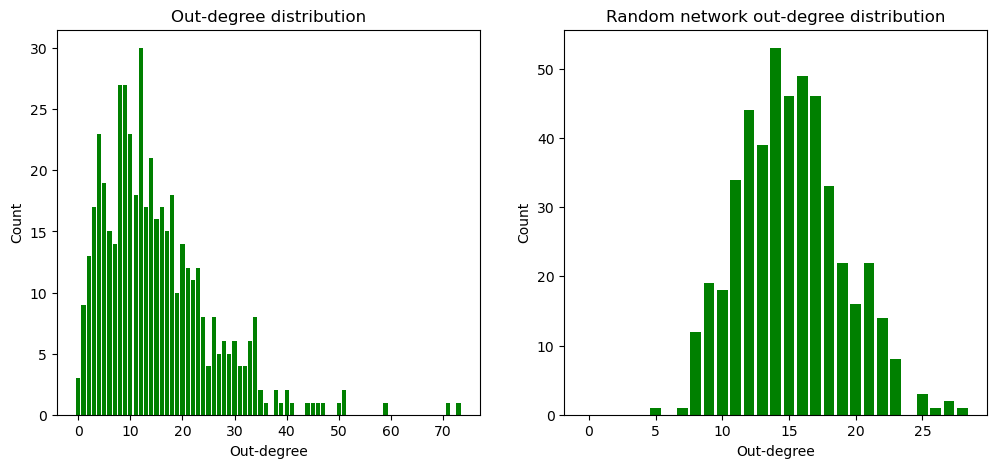

In [91]:
# The out degrees for G
out_degrees = [G_largest.out_degree(n) for n in G_largest.nodes()]

# Making a random network with same amount of nodes and edges
p = num_edges / (num_nodes * (num_nodes - 1))
G_random = nx.gnp_random_graph(num_nodes, p, directed=True)
rnd_out_degrees = [G_random.out_degree(n) for n in G_random.nodes()]

# Making histograms for G and the random network
out_hist, out_bins = np.histogram(out_degrees, bins=range(max(out_degrees)+2))
rnd_out_hist, rnd_out_bins = np.histogram(rnd_out_degrees, bins=range(max(rnd_out_degrees)+2))

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].bar(out_bins[:-1], out_hist, color='g')
axes[0].set_title("Out-degree distribution")
axes[0].set_xlabel("Out-degree")
axes[0].set_ylabel("Count")

axes[1].bar(rnd_out_bins[:-1], rnd_out_hist, color='g')
axes[1].set_title("Random network out-degree distribution")
axes[1].set_xlabel("Out-degree")
axes[1].set_ylabel("Count")

**Next we find the 5 most connected artists:**

In [92]:
# Getting the dictionary of the in and out degrees:
in_degrees = dict(G_largest.in_degree())   
out_degrees = dict(G_largest.out_degree()) 

# Sorting the list and getting top 5
top_in = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
top_out = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 by in-degree:", top_in)
print("Top 5 by out-degree:", top_out)

Top 5 by in-degree: [('Led_Zeppelin', 119), ('Bob_Dylan', 95), ('Queen_(band)', 88), ('Metallica', 85), ('David_Bowie', 83)]
Top 5 by out-degree: [('Alice_in_Chains', 73), ('Deep_Purple', 71), ('Black_Sabbath', 59), ('Def_Leppard', 51), ('Bryan_Adams', 51)]


It makes sence that the artists with the most in-degrees are very popular artists/bands, and has therefore been linked by many others.

It's a bit more difficult to see if the top 5 of the out-degrees makes sence. These are bands that have been very active with working with other bands and therefore links to mangy others.

**Now we find the 10 wikipages with the longest content.**

In [99]:
content_lengths = {
    node: (data.get("len_of_content")) 
    for node, data in G_largest.nodes(data=True)
}

top10 = sorted(content_lengths.items(), key = lambda x: x[1], reverse=True)[:10]

print("The 10 pages with the most content:")

for node, count in top10:
    print(node, ":", count)

The 10 pages with the most content:
Guns_N'_Roses : 60850
Coldplay : 47026
Queen_(band) : 46175
Marilyn_Manson_(band) : 46032
The_Rolling_Stones : 44022
U2 : 43048
Bob_Dylan : 42510
David_Bowie : 42415
Paul_McCartney : 42407
Elton_John : 41255


# Visualizing the network

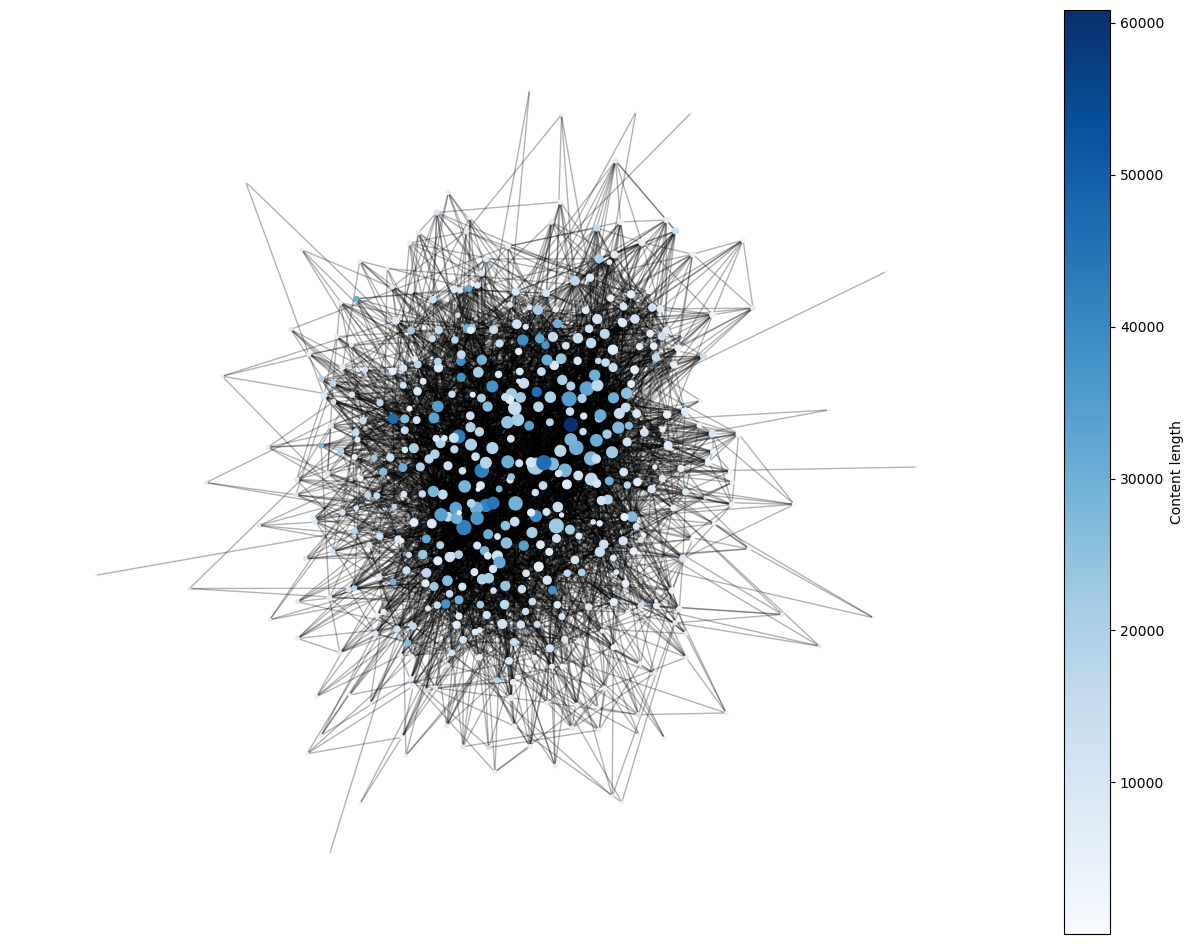

In [161]:
G_ud = G_largest.to_undirected()

# Finde node size
degrees = dict(G_ud.degree())
node_sizes = [deg for deg in degrees.values()] 

# Node colors
content_lengths = nx.get_node_attributes(G_ud, "len_of_content")
node_colors = [content_lengths.get(n, 0) for n in G_ud.nodes()]

# Drawing the network
plt.figure(figsize=(16,12))
pos = nx.spring_layout(G_ud, seed=40)

nodes = nx.draw_networkx_nodes(G_ud, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Blues)
nx.draw_networkx_edges(G_ud, pos, alpha=0.3)
plt.colorbar(nodes, label="Content length")
plt.axis("off")
plt.show()